In [1]:
import os
from enum import Enum
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing
import pandas as pd
import rfcnt


def dh_from_tp(tp: dict, length: int = None) -> np.ndarray:
    """Calculate the damage history from turning points information.
    """
    if length is None:
        length = tp[:, 0].max()  # indices are base 1!
    assert length >= tp[:, 0].max()
    dh = np.zeros(shape=length, dtype=np.double)
    # Distribute partial damages from turning points over time
    dh[tp[:, 0].astype(int) - 1] = tp[:, 2]
    return dh

In [2]:
# Load data series

data = pd.read_csv(
    os.path.join("../tests/", "long_series.csv"), header=None)
data = data.to_numpy().squeeze()

class_count = 50
class_range = data.ptp()
class_width = class_range / (class_count - 1)
class_offset = data.min() - class_width / 2

In [3]:
def inspect_rfc(data: np.typing.ArrayLike) -> tuple:
    """Do rainflow counting with standard arguments.
    """
    return rfcnt.rfc(
        data,
        class_count=class_count,
        class_offset=class_offset,
        class_width=class_width,
        hysteresis=class_width,
        spread_damage=rfcnt.SDMethod.FULL_P2,           # assign damage for closed cycles to 2nd turning point
        residual_method=rfcnt.ResidualMethod._NO_FINALIZE,  # don't consider residues and leave internal sequence open
        wl={"sd": 1e3, "nd": 1e7, "k": 5})


def inspect_sequence(data: np.typing.ArrayLike, max_len: int = 0) -> tuple:
    """Inspect the damage history by applying rainflow countings successive for one more data point at a time.
    Consider:
    At this point of view, damage accumulated until to `i` is attributed to the datapoint at `i`, which is neither P2, nor P3!
    This is noticeable in that the course of the line shows an apparent latency.
    """
    seq_damage = np.zeros(shape=data.size)  # Init
    for i in range(len(data)):
        res = inspect_rfc(data[:i+1])  # Data points from indices 0 to i, including i itself
        if not np.isclose(res["tp"][:, 2].sum(), res["damage"], rtol=1e-10):
            assert False  # Not occuring: Damage is entirely distributed over turning points
        seq_damage[i] = res["damage"]
    return inspect_rfc(data), seq_damage

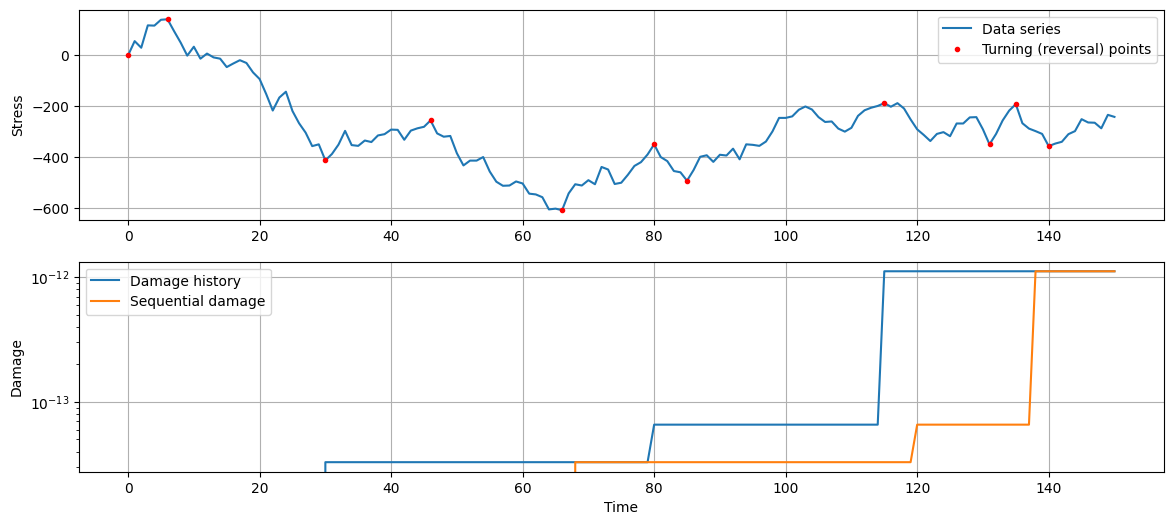

In [4]:
# Get a close look at the first 150 data points

chunk = data[:151]
res, seq = inspect_sequence(chunk)

_, ax = plt.subplots(2, 1, figsize=(14, 6))

ax[0].plot(chunk, label="Data series")
ax[0].plot(res["tp"][:, 0]-1, res["tp"][:, 1], "ro", markersize=3, label="Turning (reversal) points")
ax[0].set_ylabel("Stress")
ax[0].grid(True, which="both")
ax[0].legend()

ax[1].semilogy(np.cumsum(res["dh"]), label="Damage history")
ax[1].semilogy(seq, label="Sequential damage")
ax[1].set_ylabel("Damage")
ax[1].set_xlabel("Time")
ax[1].grid(True)
ax[1].legend()

plt.show()

Original data shape: (10001,)
Data shape of `dh` (10001,)


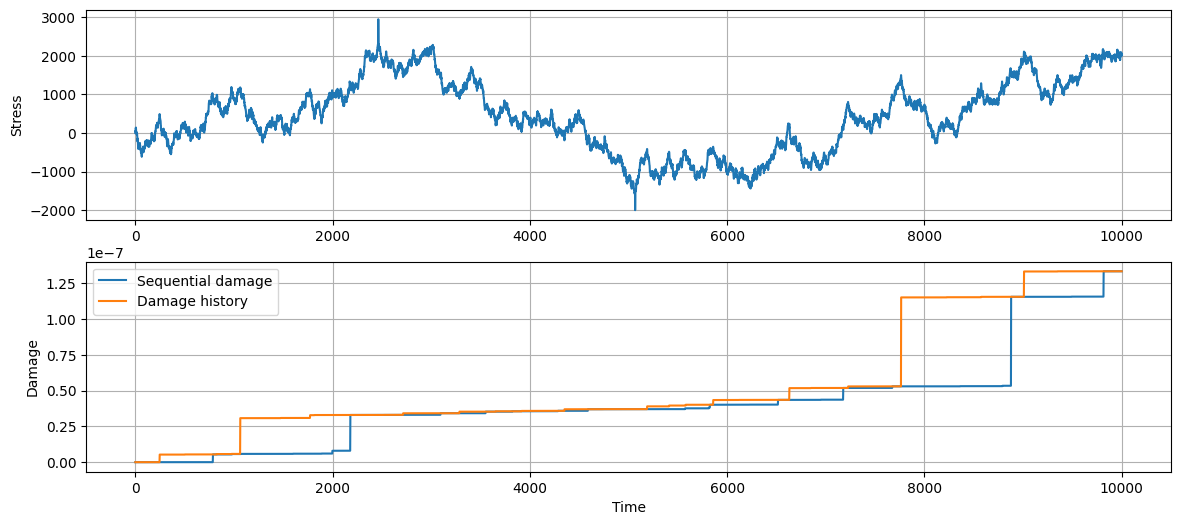

In [5]:
# Inspect entire data

res, seq = inspect_sequence(data)

print("Original data shape:", data.shape)
print("Data shape of `dh`", res["dh"].shape)

# Sanity check for damage history: Compare with reconstruction from turning points
assert np.isclose(res["dh"], dh_from_tp(res["tp"], res["dh"].size), rtol=1e-10).all()

fig, axs = plt.subplots(2,1, figsize=(14,6))
axs[0].plot(data, label="Data series")
axs[0].grid(True, which="both")
axs[0].set_ylabel('Stress')

axs[1].plot(seq, label='Sequential damage')
axs[1].plot(np.cumsum(res["dh"]), label='Damage history')

axs[1].grid(True, which="both")
axs[1].set_ylabel('Damage')
axs[1].set_xlabel('Time')
axs[1].legend(loc='best')

plt.show()